In [2]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 2.8 MB/s eta 0:00:54
   ---------------------------------------- 1.8/150.0 MB 5.0 MB/s eta 0:00:30
    --------------------------------------- 2.4/150.0 MB 4.9 MB/s eta 0:00:30
   - -------------------------------------- 5.0/150.0 MB 6.4 MB/s eta 0:00:23
   - -------------------------------------- 6.0/150.0 MB 6.6 MB/s eta 0:00:22
   - -------------------------------------- 6.0/150.0 MB 6.6 MB/s eta 0:00:22
   -- ------------------------------------- 9.2/150.0 MB 6.7 MB/s eta 0:00:21
   -- ------------------------------------- 10.5/150.0 MB 6.8 MB/s eta 0:00:21
   --- ------------------------------------ 11.8/150.0 MB 6.5 MB/s eta 0:00:22
   --- ------------------------------------ 12.1/150.0 MB 6.5 MB/s eta 0:00:22
   --- ------------------------------------ 12.8/150.0 MB 5.7 MB/s eta 0:00


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import re
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as XGBRegressor
from sklearn.inspection import permutation_importance
import re

In [2]:
def load_latest_data(prefix='unegui_data_'):
    """Load the most recent CSV file with the given prefix"""
    files = [f for f in os.listdir('.') if f.startswith(prefix) and f.endswith('.csv')]
    if not files:
        raise FileNotFoundError(f"No CSV files with prefix '{prefix}' found")
    
    latest_file = max(files)
    print(f"Loading data from {latest_file}")
    return pd.read_csv(latest_file, encoding='utf-8-sig')



In [3]:
# Try to load both rental and sales data if available
try:
    rental_df = load_latest_data(prefix='unegui_data_')
    print(f"Loaded rental data: {rental_df.shape[0]} records")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    rental_df = None

try:
    # Assuming your sales data has a different prefix
    sales_df = load_latest_data(prefix='unegui_sales_data_')
    print(f"Loaded sales data: {sales_df.shape[0]} records")
except FileNotFoundError as e:
    print(f"Warning: {e}")
    sales_df = None

Loading data from unegui_data_20250326.csv
Loaded rental data: 10793 records
Loading data from unegui_sales_data_20250325.csv
Loaded sales data: 11395 records


In [4]:

# Combine rental and sales data into one (if both are available)
if rental_df is not None and sales_df is not None:
    rental_df['Type'] = 'Rental'
    sales_df['Type'] = 'Sale'
    combined_df = pd.concat([rental_df, sales_df], ignore_index=True)
elif rental_df is not None:
    rental_df['Type'] = 'Rental'
    combined_df = rental_df
elif sales_df is not None:
    sales_df['Type'] = 'Sale'
    combined_df = sales_df

In [5]:
from datetime import datetime, timedelta  # Added timedelta import

# Convert 'Scraped_date' to datetime
combined_df['Scraped_date'] = pd.to_datetime(combined_df['Scraped_date'], errors='coerce')

# Function to fix 'Нийтэлсэн' (Posted Date) based on 'Scraped_date'
def fix_posted_date(row):
    # If 'Нийтэлсэн' contains 'Өнөөдөр' (Today), replace with today's date
    if 'Өнөөдөр' in str(row['Нийтэлсэн']):
        return row['Scraped_date'].replace(hour=datetime.now().hour, minute=datetime.now().minute, second=0)
    # If 'Нийтэлсэн' contains 'Өчигдөр' (Yesterday), replace with yesterday's date
    elif 'Өчигдөр' in str(row['Нийтэлсэн']):
        yesterday = datetime.now() - timedelta(1)
        return yesterday.replace(hour=datetime.now().hour, minute=datetime.now().minute, second=0)
    else:
        # Otherwise, just convert the 'Нийтэлсэн' date
        return pd.to_datetime(row['Нийтэлсэн'], errors='coerce')

# Apply the function to the 'Нийтэлсэн' (Posted Date) column
combined_df['Fixed Posted Date'] = combined_df.apply(fix_posted_date, axis=1)

# Check the result
print(combined_df[['Нийтэлсэн', 'Fixed Posted Date', 'Scraped_date']].head())

       Нийтэлсэн   Fixed Posted Date Scraped_date
0  Өнөөдөр 15:01 2025-11-03 14:07:00   2025-11-03
1  Өнөөдөр 12:39 2025-11-03 14:07:00   2025-11-03
2  Өнөөдөр 12:09 2025-11-03 14:07:00   2025-11-03
3  Өнөөдөр 11:52 2025-11-03 14:07:00   2025-11-03
4  Өнөөдөр 09:41 2025-11-03 14:07:00   2025-11-03


In [6]:
def extract_location_details(combined_df):
    combined_df = combined_df.copy()

    # Split the 'Байршил' column into district and sub-district/area
    combined_df[['District', 'Sub-District']] = combined_df['Байршил'].str.split(',', n=1, expand=True)

    # Clean the District and Sub-District columns (strip leading/trailing whitespaces)
    combined_df['District'] = combined_df['District'].str.strip()
    combined_df['Sub-District'] = combined_df['Sub-District'].str.strip()

    return combined_df

# Apply the function to extract location details
combined_df = extract_location_details(combined_df)

# Display a sample to ensure it worked
print(combined_df[['Байршил', 'District', 'Sub-District']].head())


                        Байршил   District        Sub-District
0          Чингэлтэй, 50 мянгат  Чингэлтэй           50 мянгат
1  Баянзүрх, Баянзүрх, Хороо 26   Баянзүрх  Баянзүрх, Хороо 26
2                Хан-Уул, Хүннү    Хан-Уул               Хүннү
3       Баянзүрх, 13-р хороолол   Баянзүрх       13-р хороолол
4  Баянзүрх, Баянзүрх, Хороо 36   Баянзүрх  Баянзүрх, Хороо 36


In [8]:
def extract_primary_district(combined_df):
    combined_df = combined_df.copy()
    combined_df['PrimaryDistrict'] = combined_df['Байршил'].str.split(',').str[0].str.strip()
    return combined_df


In [9]:
# Apply the function to extract the primary district
combined_df = extract_primary_district(combined_df)

# Check the first few rows to see if the 'PrimaryDistrict' column was added
print(combined_df.head())


      Шал       Тагт  Гараж   Цонх  Хаалга    Цонхнытоо  Барилгынявц  \
0  Паркет    Тагтгүй  Цонх:  Вакум  Бүргэд          3+1          NaN   
1  Паркет  1 тагттай  Цонх:  Вакум  Бүргэд          3+1          NaN   
2  Паркет  1 тагттай  Цонх:  Вакум  Бүргэд          3+1          NaN   
3  Паркет  1 тагттай  Цонх:  Вакум  Бүргэд          4+1          NaN   
4  Паркет  2 тагттай  Цонх:  Вакум  Бүргэд  Тохиролцоно          NaN   

   Ашиглалтандорсонон Барилгындавхар    Талбай  ...  ӨрөөнийТоо  \
0                 NaN              4  30 м² м²  ...      1 өрөө   
1                 NaN             16     76 м²  ...      2 өрөө   
2                 NaN             19  50 м² м²  ...      2 өрөө   
3                 NaN              9     95 м²  ...      3 өрөө   
4                 NaN             10  99,05 м²  ...      3 өрөө   

                                        Зарыг гарчиг  \
0        Улсын их дэлгүүрийн баруун талд 1 өрөө байр   
1  Бзд дүнжингарав худалдааны урд чухаг-2 хотхонд...

In [10]:
def clean_sub_district(combined_df):
    combined_df = combined_df.copy()

    # Remove extra spaces
    combined_df['Sub-District'] = combined_df['Sub-District'].str.strip()

    # Handle NaN or non-string values and remove everything before the last comma
    combined_df['Sub-District'] = combined_df['Sub-District'].apply(lambda x: x.rsplit(',', 1)[-1].strip() if isinstance(x, str) else x)

    return combined_df

# Apply the function to clean the Sub-District column
combined_df = clean_sub_district(combined_df)

# Display a sample to check the cleaned Sub-District
print(combined_df[['Байршил', 'District', 'Sub-District']].head())


                        Байршил   District   Sub-District
0          Чингэлтэй, 50 мянгат  Чингэлтэй      50 мянгат
1  Баянзүрх, Баянзүрх, Хороо 26   Баянзүрх       Хороо 26
2                Хан-Уул, Хүннү    Хан-Уул          Хүннү
3       Баянзүрх, 13-р хороолол   Баянзүрх  13-р хороолол
4  Баянзүрх, Баянзүрх, Хороо 36   Баянзүрх       Хороо 36


In [11]:
# Get the number of unique Sub-Districts
unique_sub_districts = combined_df['Sub-District'].nunique()

# Print the number of unique Sub-Districts
print(f'Number of unique Sub-Districts: {unique_sub_districts}')


Number of unique Sub-Districts: 215


In [12]:
combined_df.tail()

,Шал,Тагт,Гараж,Цонх,Хаалга,Цонхнытоо,Барилгынявц,Ашиглалтандорсонон,Барилгындавхар,Талбай,...,ӨрөөнийТоо,Зарыг гарчиг,Зарын тайлбар,Нийтэлсэн,ad_id,Type,Fixed Posted Date,District,Sub-District,PrimaryDistrict
22183,Паркет,1 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,9.0,34.04 м²,...,1 өрөө,Амгаланд наран амгалан хотхонд 34.04м2 1 өрөө ...,Амгаланд Амгалан захын урд Наран Амгалан хотхо...,2025-03-09 17:56,7078cb271c83a9d8432d471a8f9385e7,Sale,2025-03-09 17:56:00,Баянзүрх,Амгалан,Баянзүрх
22184,Паркет,2 тагттай,Байхгүй,Вакум,Төмөр,Ашиглалтад орсон,NaN,NaN,5.0,83.0 м²,...,4 өрөө,Яармаг garden city хотхонд 83м2 4 өрөө байр,Яармаг Garden city хотхонд 83м2 4 өрөө зарна -...,2025-03-07 16:44,dfc3467fc89db3fe333dc3a6ea23cdea,Sale,2025-03-07 16:44:00,Хан-Уул,Яармаг,Хан-Уул
22185,Паркет,1 тагттай,Байгаа,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,9.0,209.0 м²,...,4 өрөө,Ubtown хотхоны зүүн талд 4 өрөө 209мкв дүплекс...,"UB town хотхоны зүүн талын байранд 208,56м2 Дү...",2025-03-06 14:56,a9e8258fdbad4c4158cfbf5ebd0c7fa0,Sale,2025-03-06 14:56:00,Хан-Уул,UB Town,Хан-Уул
22186,Паркет,1 тагттай,Байгаа,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,16.0,64.2 м²,...,2 өрөө,Цэцэрлэгт хүрээлэнгийн хойно time tower хотхон...,"📣#time_tower хотхонд 64.2 мкв, #2өрөө #байр ху...",2025-03-05 11:03,37df977950786b71acae57f73495cbe6,Sale,2025-03-05 11:03:00,Баянзүрх,Хороо 26,Баянзүрх
22187,Паркет,2 тагттай,Байхгүй,Вакум,Бүргэд,Ашиглалтад орсон,NaN,NaN,16.0,97.0 м²,...,3 өрөө,Tuul view хотхонд 97.26m2 3 өрөө байр,Яармагийн гүүрний баруун талд байрлах TUUL VIE...,2025-02-25 14:48,10ba6d9743062941429cd1ef520309f3,Sale,2025-02-25 14:48:00,Хан-Уул,Яармаг,Хан-Уул


In [13]:
renting_df = combined_df[combined_df['Type'] == 'Rental']


In [14]:
df =renting_df

# Important feature

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import re

# Step 1: Process the data carefully
df_processed = df.copy()

# Process numeric features
def extract_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    numbers = re.findall(r'\d+(?:,\d+)?', str(x))
    if numbers:
        return float(numbers[0].replace(',', '.'))
    return np.nan

# Extract price (target variable)
df_processed['Price_numeric'] = df_processed['Үнэ'].apply(extract_numeric)

# Extract area 
df_processed['Area_numeric'] = df_processed['Талбай'].apply(extract_numeric)

# Extract room count
df_processed['Room_count'] = df_processed['ӨрөөнийТоо'].apply(lambda x: 
    float(re.findall(r'\d+', str(x))[0]) if not pd.isna(x) and re.findall(r'\d+', str(x)) else np.nan)

# Handle categorical variables one by one
cat_features = ['Шал', 'Тагт', 'District', 'Type']
for col in cat_features:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].fillna('missing'))



In [32]:
# Step 2: Create feature matrix with verified columns
# First create a list of features we know exist
features_to_use = []

# Add categorical encoded features we created
for col in cat_features:
    encoded_col = f'{col}_encoded'
    if encoded_col in df_processed.columns:
        features_to_use.append(encoded_col)

# Add numeric features we created
numeric_features = ['Area_numeric', 'Room_count']
for col in numeric_features:
    if col in df_processed.columns:
        features_to_use.append(col)

# Print features being used
print("Features being used:", features_to_use)
print("Number of features:", len(features_to_use))


Features being used: ['Шал_encoded', 'Тагт_encoded', 'District_encoded', 'Type_encoded', 'Area_numeric', 'Room_count']
Number of features: 6


In [33]:

# Step 3: Prepare feature matrix and target variable
X = df_processed[features_to_use].copy()
y = df_processed['Price_numeric'].copy()

# Handle missing values
X = X.fillna(X.mean())
valid_indices = y.notna()
X = X[valid_indices]
y = y[valid_indices]

print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")


Final X shape: (10793, 6)
Final y shape: (10793,)



Feature Importance:
            Feature  Importance
4      Area_numeric    0.845906
2  District_encoded    0.069297
5        Room_count    0.045913
1      Тагт_encoded    0.033092
0       Шал_encoded    0.005792
3      Type_encoded    0.000000


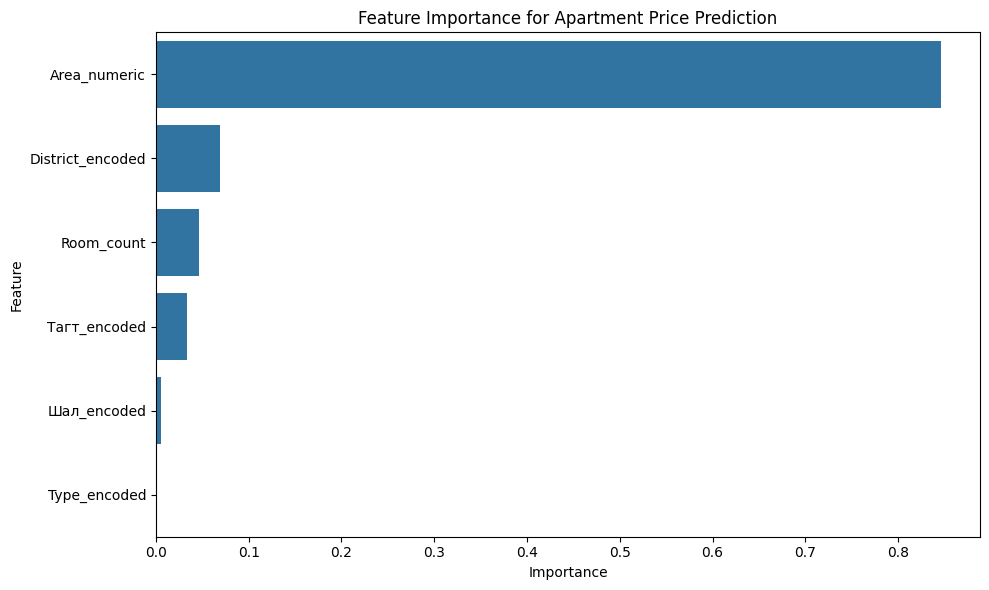

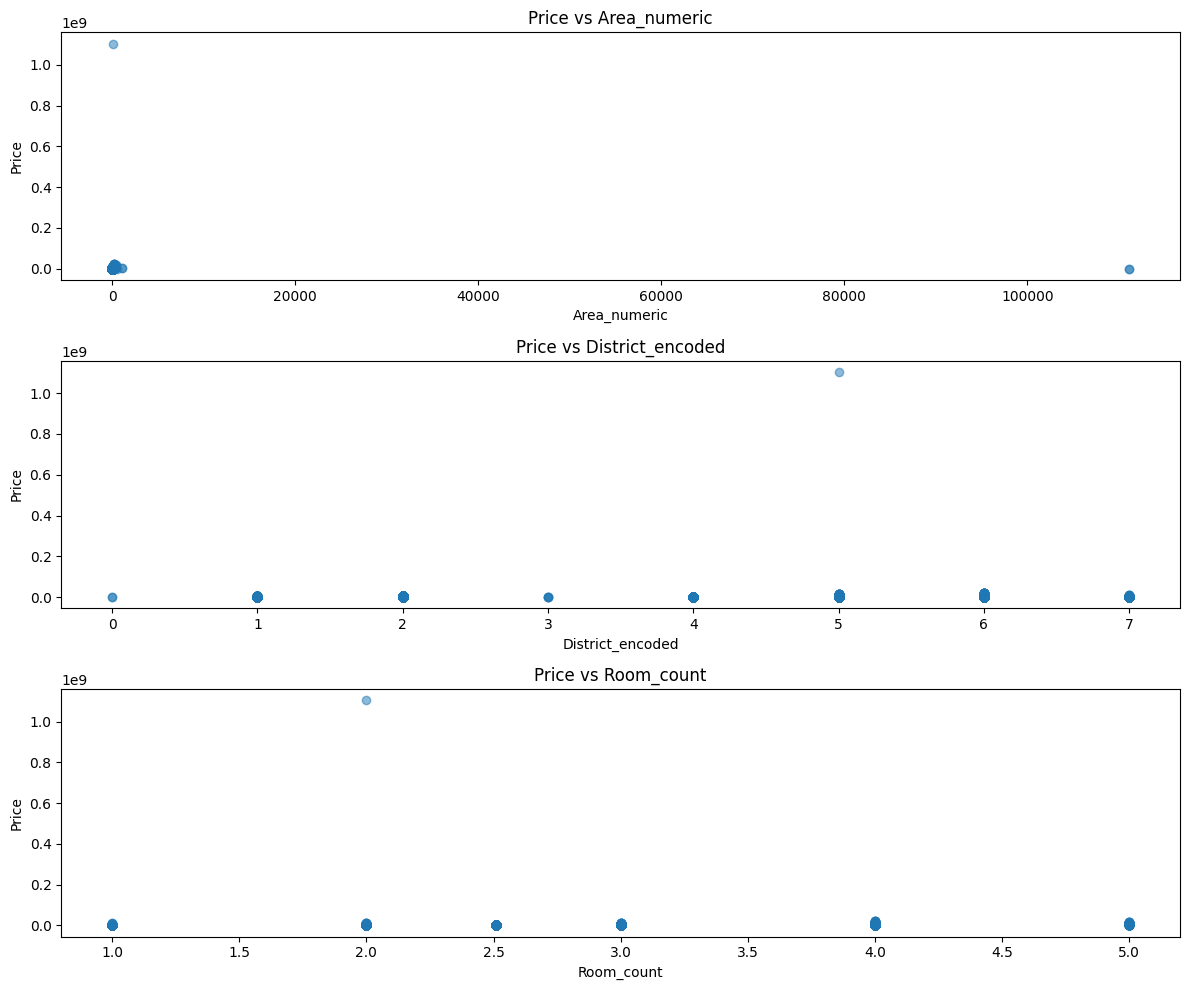

In [34]:

# Step 4: Train a model to analyze feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Analyze and visualize feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Apartment Price Prediction')
plt.tight_layout()
plt.show()

# Step 6: Visualize relationship between top features and price
top_features = feature_importance['Feature'].head(3).tolist()

plt.figure(figsize=(12, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(3, 1, i)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.title(f'Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

## Perdicting the price overtime

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from datetime import datetime
import re

# Let's prepare the data for time series modeling
df_time = df.copy()

# Extract date information
# First, convert 'Fixed Posted Date' to datetime
df_time['date'] = pd.to_datetime(df_time['Fixed Posted Date'], errors='coerce')

# Extract time-based features
df_time['year'] = df_time['date'].dt.year
df_time['month'] = df_time['date'].dt.month
df_time['day'] = df_time['date'].dt.day
df_time['day_of_week'] = df_time['date'].dt.dayofweek
df_time['quarter'] = df_time['date'].dt.quarter


Data timespan: 2024-10-16 10:46:00 to 2025-11-03 14:07:00
Training set size: 8064
Test set size: 2016

Training Linear Regression...
Linear Regression - RMSE: 1544726.91, MAE: 1104301.53, R2: 0.32

Training Random Forest...
Random Forest - RMSE: 4710539.19, MAE: 692509.70, R2: -5.29

Training Gradient Boosting...
Gradient Boosting - RMSE: 3386553.04, MAE: 829122.95, R2: -2.25

Training XGBoost...
XGBoost - RMSE: 933384.36, MAE: 546523.11, R2: 0.75

Best model: XGBoost with RMSE: 933384.36

Training final XGBoost model on all data...


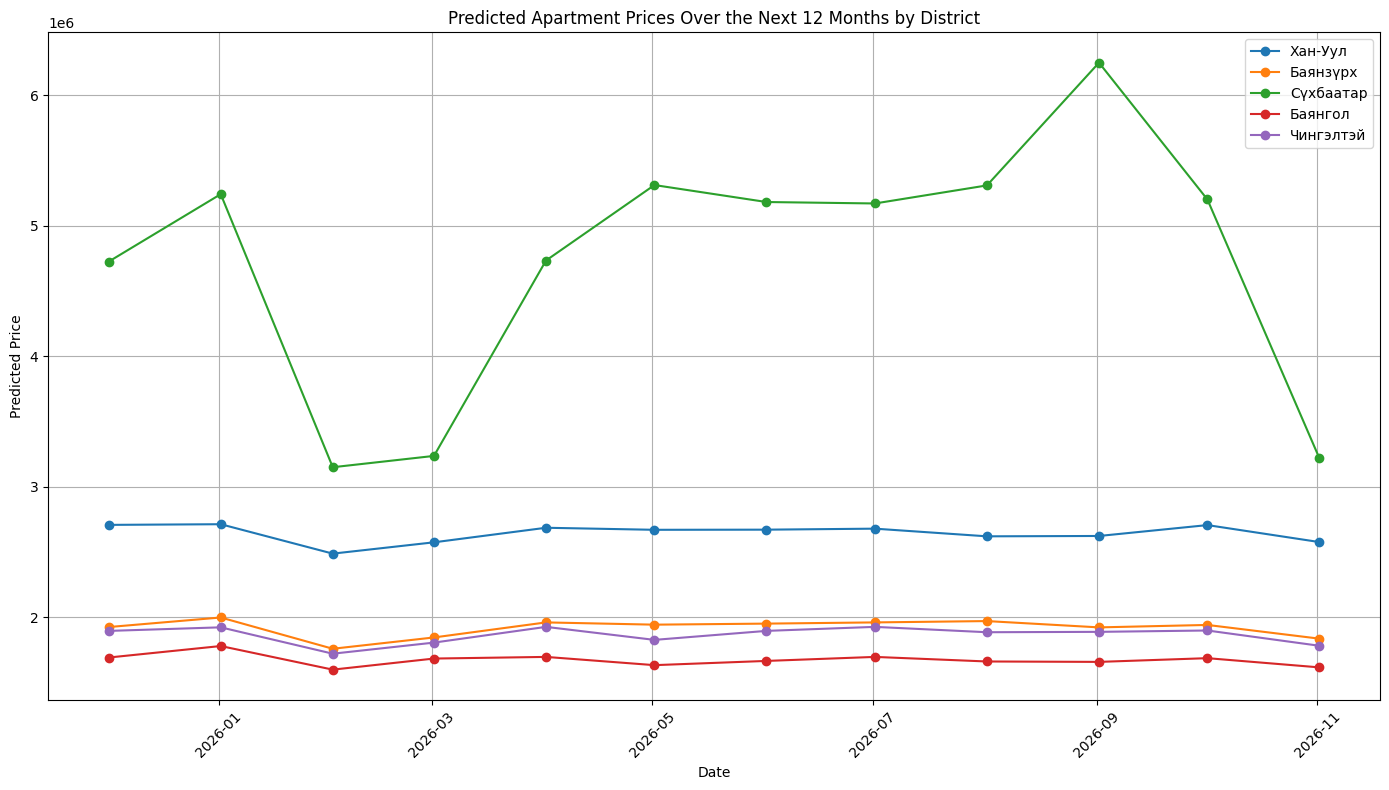

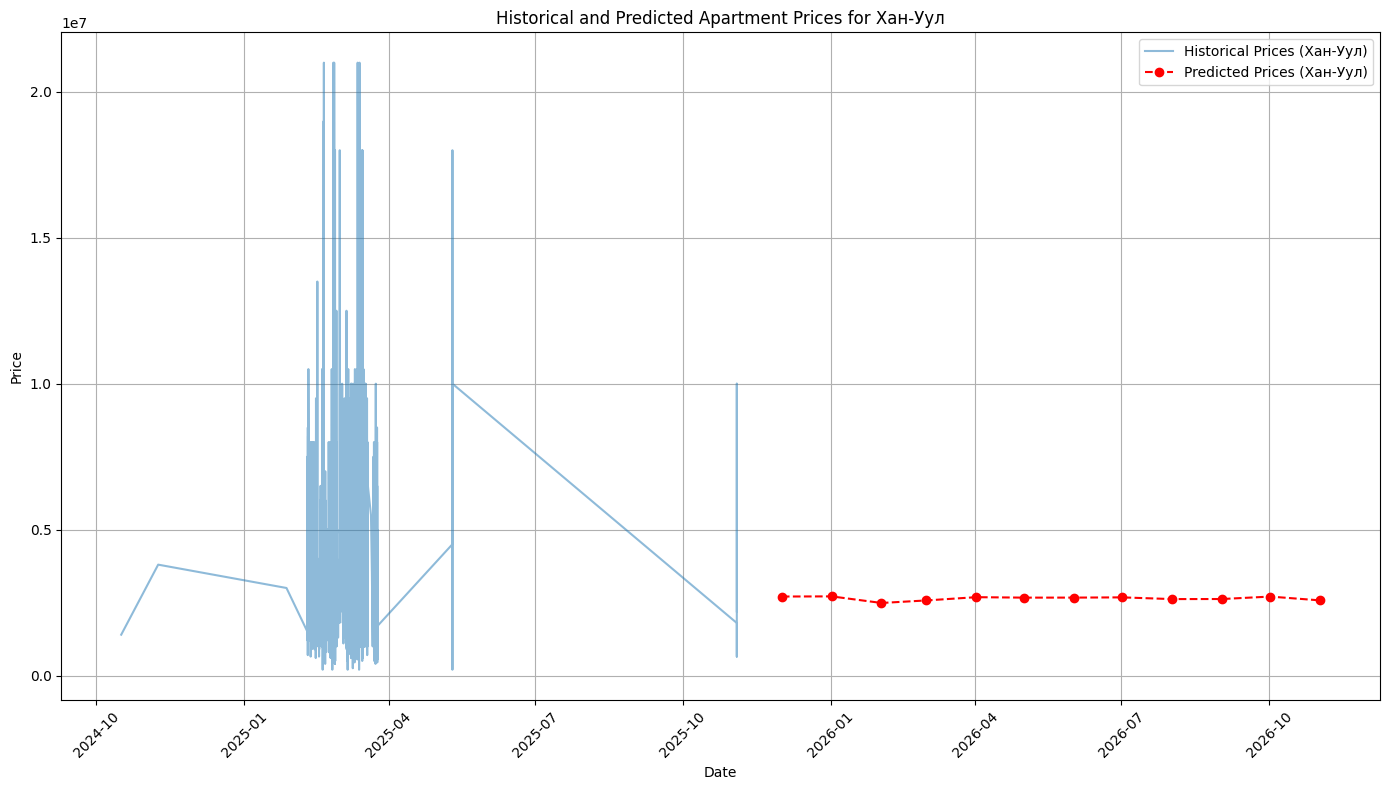

Model saved to apartment_price_prediction_model.pkl


In [16]:

# Extract numeric price (target variable)
def extract_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    numbers = re.findall(r'\d+(?:,\d+)?', str(x))
    if numbers:
        return float(numbers[0].replace(',', '.'))
    return np.nan

df_time['price'] = df_time['Үнэ'].apply(extract_numeric)

# Extract key features
df_time['area'] = df_time['Талбай'].apply(extract_numeric)
df_time['room_count'] = df_time['ӨрөөнийТоо'].apply(lambda x: 
    float(re.findall(r'\d+', str(x))[0]) if not pd.isna(x) and re.findall(r'\d+', str(x)) else np.nan)

# Keep only rows with valid dates and prices
df_time = df_time.dropna(subset=['date', 'price'])

# Check the timespan of your data
min_date = df_time['date'].min()
max_date = df_time['date'].max()
print(f"Data timespan: {min_date} to {max_date}")

# Create additional time-related features
df_time['days_since_start'] = (df_time['date'] - min_date).dt.days

# For long-term trends, create a cumulative average price by district
df_time['district'] = df_time['District'].fillna('Unknown')
district_avg_prices = df_time.groupby(['district', 'year', 'month'])['price'].mean().reset_index()
district_avg_prices = district_avg_prices.sort_values(['district', 'year', 'month'])
district_avg_prices['rolling_avg_price'] = district_avg_prices.groupby('district')['price'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Merge this back to the main dataframe
df_time = pd.merge(
    df_time, 
    district_avg_prices[['district', 'year', 'month', 'rolling_avg_price']], 
    on=['district', 'year', 'month'], 
    how='left'
)

# Select features for the model
feature_columns = [
    'area', 'room_count', 'year', 'month', 'quarter', 'day_of_week',
    'days_since_start', 'rolling_avg_price'
]

# Add categorical features
categorical_features = ['Type', 'district']

# Prepare data for modeling
X = df_time[feature_columns + categorical_features].copy()
y = df_time['price']

# Handle missing values
for col in feature_columns:
    if col in X.columns:
        X[col] = X[col].fillna(X[col].median())

for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].fillna('Unknown')

# Create preprocessor
numeric_features = [col for col in feature_columns if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Time series split to respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Try different models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

# Create chronological train/test split (more appropriate for time series)
train_idx = df_time['date'] < df_time['date'].quantile(0.8)
test_idx = ~train_idx

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

# Find the best model
best_model = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
print(f"\nBest model: {best_model} with RMSE: {results[best_model]['RMSE']:.2f}")

# Train the best model on all data
print(f"\nTraining final {best_model} model on all data...")
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model])
])
final_pipeline.fit(X, y)

# Function to predict future prices
def predict_future_prices(model, last_data, districts, future_months=12):
    """
    Predict apartment prices for the next few months by district.
    
    Args:
        model: Trained pipeline
        last_data: The most recent data
        districts: List of districts to predict for
        future_months: Number of months to predict into the future
        
    Returns:
        DataFrame with predictions
    """
    # Get the latest date in the data
    latest_date = df_time['date'].max()
    
    # Create future dates
    future_dates = pd.date_range(
        start=latest_date + pd.Timedelta(days=1),
        periods=future_months,
        freq='MS'  # Month start
    )
    
    # Create prediction template
    future_df = pd.DataFrame()
    
    # For each district, make predictions
    for district in districts:
        # Get average values for this district
        district_data = df_time[df_time['district'] == district]
        
        if len(district_data) == 0:
            continue
            
        # Get median values for numeric features
        median_area = district_data['area'].median()
        median_rooms = district_data['room_count'].median()
        common_type = district_data['Type'].mode()[0]
        
        # Create future records for this district
        district_future = pd.DataFrame({
            'date': future_dates,
            'district': district,
            'Type': common_type,
            'area': median_area,
            'room_count': median_rooms,
            'year': future_dates.year,
            'month': future_dates.month,
            'quarter': future_dates.quarter,
            'day_of_week': future_dates.dayofweek,
            'days_since_start': (future_dates - min_date).days,
            # We'll need to iteratively predict for rolling_avg_price
            'rolling_avg_price': np.nan
        })
        
        # Get the latest rolling average for this district
        latest_rolling_avg = district_data['rolling_avg_price'].iloc[-1] if not district_data['rolling_avg_price'].isna().all() else df_time['price'].median()
        
        # Initialize rolling avg
        prev_rolling_avg = latest_rolling_avg
        
        # For each future month, predict and update the rolling average
        for i in range(len(district_future)):
            district_future.iloc[i, district_future.columns.get_loc('rolling_avg_price')] = prev_rolling_avg
            
            # Prepare the feature vector for this prediction
            X_pred = district_future.iloc[[i]][feature_columns + categorical_features]
            
            # Predict the price
            pred_price = model.predict(X_pred)[0]
            
            # Update rolling average (simple approach - could be more sophisticated)
            prev_rolling_avg = 0.7 * prev_rolling_avg + 0.3 * pred_price
            
        # Add predictions to the result
        district_future['predicted_price'] = model.predict(district_future[feature_columns + categorical_features])
        future_df = pd.concat([future_df, district_future])
    
    return future_df

# Get top 5 districts with the most data
top_districts = df_time['district'].value_counts().head(5).index.tolist()

# Make predictions for the next 12 months
future_predictions = predict_future_prices(final_pipeline, df_time, top_districts, future_months=12)

# Plot price predictions by district
plt.figure(figsize=(14, 8))
for district in top_districts:
    district_pred = future_predictions[future_predictions['district'] == district]
    plt.plot(district_pred['date'], district_pred['predicted_price'], marker='o', label=district)

plt.title('Predicted Apartment Prices Over the Next 12 Months by District')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot historical and predicted prices for a specific district
example_district = top_districts[0]
plt.figure(figsize=(14, 8))

# Historical data
historical = df_time[df_time['district'] == example_district].sort_values('date')
plt.plot(historical['date'], historical['price'], label=f'Historical Prices ({example_district})', alpha=0.5)

# Future predictions
future = future_predictions[future_predictions['district'] == example_district]
plt.plot(future['date'], future['predicted_price'], 'r--', marker='o', label=f'Predicted Prices ({example_district})')

plt.title(f'Historical and Predicted Apartment Prices for {example_district}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the model for future use
import joblib
joblib.dump(final_pipeline, 'apartment_price_prediction_model.pkl')
print("Model saved to apartment_price_prediction_model.pkl")